
<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we will use multiple classification algorithms to predict loan repayment

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import seaborn as sns
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
np.random.seed(7)

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [3]:
file_name = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv'

### Load Data From CSV File


In [4]:
df = pd.read_csv(file_name)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [6]:
df.shape

(346, 8)

### Convert to date time object


In [7]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [8]:
df['loan_status'].value_counts()

loan_status
PAIDOFF       260
COLLECTION     86
Name: count, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:

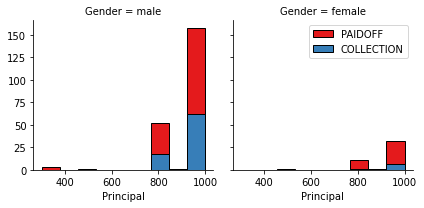

In [9]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

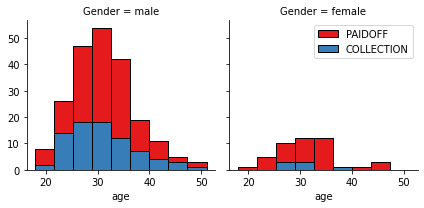

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


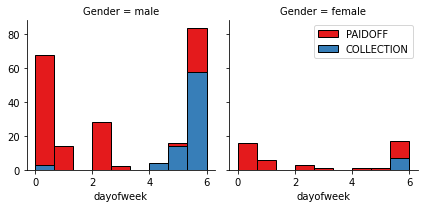

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


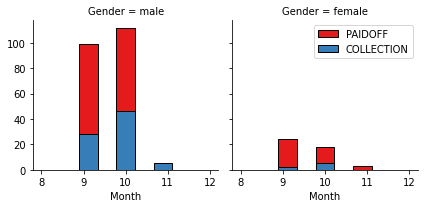

In [12]:
df['Month'] = df.due_date.dt.month
bins = np.linspace(df.Month.min() -1, df.Month.max()+1, 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Month', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,10,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,10,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,9,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,10,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,10,1


## Convert Categorical features to numerical values


Let's look at gender:


In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: proportion, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [15]:
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1


In [16]:
df['deadline'] = df['due_date'] - df['effective_date']
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29 days
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29 days
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14 days
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1,29 days
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1,29 days


In [17]:
df['deadline'] = df['deadline'].dt.days

In [18]:
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,Month,weekend,deadline
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,10,0,29
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,10,0,29
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,9,0,14
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,10,1,29
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,10,1,29


## One Hot Encoding

#### How about education?


In [19]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: proportion, dtype: float64

#### Features before One Hot Encoding


In [20]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [21]:
Feature = df[['Principal','terms','age','Gender','weekend', 'dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,False,True,False
1,1000,30,33,1,0,3,True,False,False
2,1000,15,27,0,0,3,False,False,True
3,1000,30,28,1,1,4,False,False,True
4,1000,30,29,0,1,4,False,False,True


### Feature Selection


Let's define feature sets, X:


In [22]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,college
0,1000,30,45,0,0,3,False,True,False
1,1000,30,33,1,0,3,True,False,False
2,1000,15,27,0,0,3,False,False,True
3,1000,30,28,1,1,4,False,False,True
4,1000,30,29,0,1,4,False,False,True


What are our lables?


In [23]:
y = df['loan_status'].map({'PAIDOFF': 0, 'COLLECTION': 1}).values
y[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [24]:
X = preprocessing.StandardScaler().fit_transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -0.26122054,  2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.26122054, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         0.12175534, -0.38170062, -0.87997669,  1.14984679]])

In [25]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

In [26]:
X_train, y_train = X, y

In [27]:
X_train.shape, y_train.shape

((346, 9), (346,))

In [28]:
trainScores={}

# Classification


Now it's time to use the training set to build an accurate model, and then test it on the test set to report its accuracy

We are going to use the following algorithm

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

# K Nearest Neighbor(KNN)

Now, let's find the best k and build the model with the highest accuracy!


In [29]:
from sklearn.neighbors import KNeighborsClassifier
bestScore = 0.0
accList = []
for k in range(3, 12):
    clf_knn = KNeighborsClassifier(n_neighbors=k, algorithm='auto')
    scores = cross_val_score(clf_knn, X, y, cv=10)
    score = scores.mean()
    accList.append(score)
    if score > bestScore:
        bestScore = score
        best_clf = clf_knn
        bestK = k
print("Best K is,", bestK, "Cross Validation Accuracy:", bestScore)
clf_knn = best_clf

Best K is, 8 Cross Validation Accuracy: 0.7579831932773109


In [30]:
clf_knn.fit(X_train, y_train)
y_pred = best_clf.predict(X_train)

In [31]:
trainScores['KNN-Jaccard'] = jaccard_score(y_train, y_pred, average='weighted')
trainScores['KNN-f1-score'] = f1_score(y_train, y_pred, average='weighted')

In [32]:
trainScores

{'KNN-Jaccard': 0.6409811474367684, 'KNN-f1-score': 0.7537693061220201}

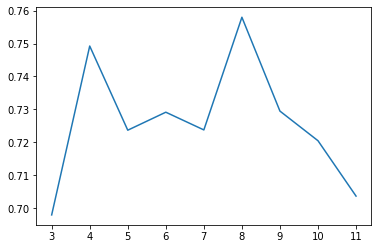

In [33]:
plt.plot(range(3, 12), accList)
plt.show()

# Decision Tree


In [34]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_train)

In [35]:
trainScores['Tree-Jaccard'] = jaccard_score(y_train, y_pred, average='weighted')
trainScores['Tree-f1-score'] = f1_score(y_train, y_pred, average='weighted')

In [36]:
trainScores

{'KNN-Jaccard': 0.6409811474367684,
 'KNN-f1-score': 0.7537693061220201,
 'Tree-Jaccard': 0.8641024234486887,
 'Tree-f1-score': 0.9249270208209849}

# Support Vector Machine


In [37]:
y_train = y_train.astype(float)

In [38]:
from sklearn import svm
clf_svm = svm.LinearSVC(random_state=7)
clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_train)

In [39]:
trainScores['SVM-Jaccard'] = jaccard_score(y_train, y_pred, average='weighted')
trainScores['SVM-f1-score'] = f1_score(y_train, y_pred, average='weighted')

In [40]:
trainScores

{'KNN-Jaccard': 0.6409811474367684,
 'KNN-f1-score': 0.7537693061220201,
 'Tree-Jaccard': 0.8641024234486887,
 'Tree-f1-score': 0.9249270208209849,
 'SVM-Jaccard': 0.5755879399362525,
 'SVM-f1-score': 0.6689062277741139}

# Logistic Regression


In [41]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(random_state=0, solver='lbfgs')
clf_log.fit(X_train, y_train)
y_pred = clf_log.predict(X_train)
y_proba = clf_log.predict_proba(X_train)

In [42]:
trainScores['LogReg-Jaccard'] = jaccard_score(y_train, y_pred, average='weighted')
trainScores['LogReg-f1-score'] = f1_score(y_train, y_pred, average='weighted')
trainScores['LogReg-LogLoss'] = log_loss(y_train, y_proba)

In [43]:
trainScores

{'KNN-Jaccard': 0.6409811474367684,
 'KNN-f1-score': 0.7537693061220201,
 'Tree-Jaccard': 0.8641024234486887,
 'Tree-f1-score': 0.9249270208209849,
 'SVM-Jaccard': 0.5755879399362525,
 'SVM-f1-score': 0.6689062277741139,
 'LogReg-Jaccard': 0.5918030777054792,
 'LogReg-f1-score': 0.6953162775444934,
 'LogReg-LogLoss': 0.43304230663767845}

# Model Evaluation using Test set


First, download and load the test set:


In [44]:
file_name =  'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'

### Load Test set for evaluation


In [45]:
test_df = pd.read_csv(file_name)
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [46]:
test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]
test_df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [47]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if x > 3 else 0)
test_df['Gender'] = test_df['Gender'].map({'male': 0, 'female': 1})

Feature = test_df[['Principal', 'terms', 'age', 'Gender', 'weekend', 'dayofweek']]
Feature = pd.concat([Feature, pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis=1, inplace=True)

X = Feature
y = test_df['loan_status'].map({'PAIDOFF': 0, 'COLLECTION': 1}).values
testy = y.astype(float)
testX = preprocessing.StandardScaler().fit_transform(X)

In [48]:
testScores={}

In [49]:
knn_pred=clf_knn.predict(testX)
testScores['KNN-Jaccard'] = jaccard_score(testy, knn_pred, average='weighted')
testScores['KNN-f1-score'] = f1_score(testy, knn_pred, average='weighted')

In [50]:
tree_pred=clf_tree.predict(testX)
testScores['Tree-Jaccard'] = jaccard_score(testy, tree_pred, average='weighted')
testScores['Tree-f1-score'] = f1_score(testy, tree_pred, average='weighted')

In [51]:
svm_pred = clf_svm.predict(testX)
testScores['SVM-Jaccard'] = jaccard_score(testy, svm_pred, average='weighted')
testScores['SVM-f1-score'] = f1_score(testy, svm_pred, average='weighted')

In [52]:
log_pred = clf_log.predict(testX)
proba = clf_log.predict_proba(testX)
testScores['LogReg-Jaccard'] = jaccard_score(testy, log_pred, average='weighted')
testScores['LogReg-f1-score'] = f1_score(testy, log_pred, average='weighted')
testScores['LogReg-LogLoss'] = log_loss(testy, proba)

In [53]:
trainScores

{'KNN-Jaccard': 0.6409811474367684,
 'KNN-f1-score': 0.7537693061220201,
 'Tree-Jaccard': 0.8641024234486887,
 'Tree-f1-score': 0.9249270208209849,
 'SVM-Jaccard': 0.5755879399362525,
 'SVM-f1-score': 0.6689062277741139,
 'LogReg-Jaccard': 0.5918030777054792,
 'LogReg-f1-score': 0.6953162775444934,
 'LogReg-LogLoss': 0.43304230663767845}

In [54]:
testScores

{'KNN-Jaccard': 0.5909465020576131,
 'KNN-f1-score': 0.7144311330357843,
 'Tree-Jaccard': 0.6301663982823403,
 'Tree-f1-score': 0.7618862861115153,
 'SVM-Jaccard': 0.5901234567901235,
 'SVM-f1-score': 0.6959228135698724,
 'LogReg-Jaccard': 0.5775681341719078,
 'LogReg-f1-score': 0.6717642373556352,
 'LogReg-LogLoss': 0.4780783817392222}

# Report

| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.5909  | 0.7144   | NA      |
| Decision Tree      | 0.6301  | 0.7618   | NA      |
| SVM                | 0.5901  | 0.6959   | NA      |
| LogisticRegression | 0.4780  | 0.6717   | 0.4780  |
